In [1]:
import os
import sys

In [2]:
os.chdir("..")
src_dir = os.path.join(os.getcwd(), "src")
sys.path.append(src_dir)

In [3]:
from typing import Dict, List

from torch_geometric.nn.models import GAT, GCN
import matplotlib.pyplot as plt

from main import silence_warnings
from data import load_and_prepare_dataset
from training import _get_scaffolds, _get_cv_splitter
from graph.pna_pipeline import PNAPipeline

In [4]:
def plot_metrics(metrics: Dict[str, List[float]]):
    plt.plot(metrics["train_aucs"], label="train-AUC")
    plt.plot(metrics["test_aucs"], label="test-AUC")
    plt.legend()

# Prepare the data

Load the data from CSV file

In [5]:
smiles, y = load_and_prepare_dataset()

2023-05-26 15:38:16 | INFO | root | Loading the EGFR dataset


Split the data with scaffold splitting strategy. We are only going to fit on the first fold here.
The scaffold of a molecule is its foundational molecular structure.
We want to ensure that the test set is made of observations with different scaffolds then the training seet in order to evaluate
performance under more realistic screening settings (where the model will most probably be applied on molecules with different scaffolds)

In [6]:
# Here we use internal methods (we don't declare them public because it is just for the sake of this notebook)
scaffolds = _get_scaffolds(smiles)
splitter = _get_cv_splitter(scaffolds, smiles)
train_indices, test_indices = next(splitter)

# Train a PNA model with default params

In [8]:
pipeline = PNAPipeline()
X = pipeline.transform_smiles(smiles)
X_train, X_test, y_train, y_test = pipeline.split_data(X, y, train_indices, test_indices)

In [8]:
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.242 - Test Loss 0.452- AUC Train 0.934 - AUC Test 0.850 : 100%|██████████| 120/120 [08:33<00:00,  4.28s/it]


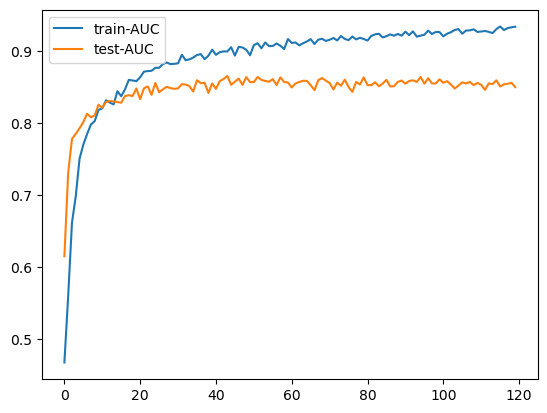

In [13]:
plot_metrics(metrics)

# Compare with GCN model

In [16]:
pipeline = PNAPipeline()
# Here we "hack" the internal model because we don't want to make any modification to the code base for the sake of this notebook
pipeline._model = GCN(in_channels=pipeline.num_atom_features, 
                      hidden_channels=64, 
                      num_layers=2,
                      out_channels=1, 
                      dropout=0.2, 
                      act="relu")
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.373 - Test Loss 0.421- AUC Train 0.816 - AUC Test 0.806 : 100%|██████████| 120/120 [02:06<00:00,  1.05s/it]


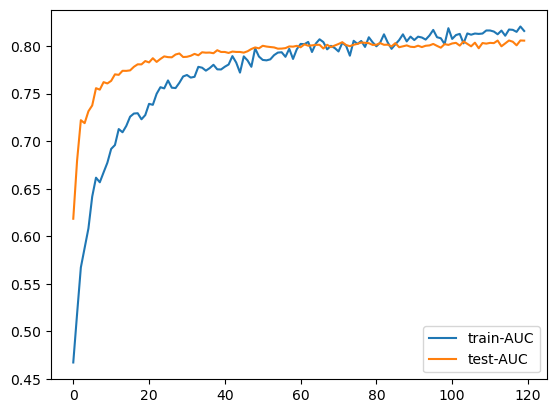

In [17]:
plot_metrics(metrics)

# Compare with GAT model

In [19]:
pipeline = PNAPipeline()
# Here we "hack" the internal model because we don't want to make any modification to the code base for the sake of this notebook
pipeline._model = GAT(in_channels=pipeline.num_atom_features, 
                      hidden_channels=64, 
                      num_layers=2,
                      out_channels=1, 
                      dropout=0.2, 
                      act="relu")
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.408 - Test Loss 0.430- AUC Train 0.766 - AUC Test 0.780 : 100%|██████████| 120/120 [03:19<00:00,  1.66s/it]


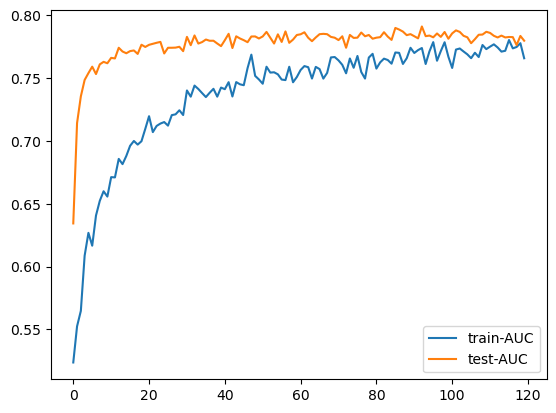

In [20]:
plot_metrics(metrics)

# Assess data augmentation

## Random atom masking

In [18]:
pipeline = PNAPipeline(augmenter_kind="rnd-mask")
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.289 - Test Loss 0.493- AUC Train 0.904 - AUC Test 0.847 : 100%|██████████| 120/120 [11:08<00:00,  5.57s/it]


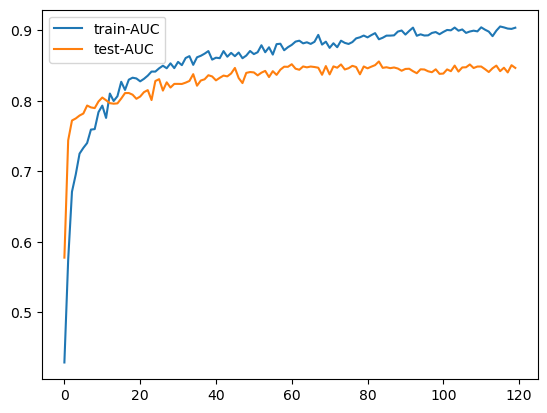

In [19]:
plot_metrics(metrics)

## Random bond deletion

In [20]:
pipeline = PNAPipeline(augmenter_kind="rnd-bond")
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.332 - Test Loss 0.459- AUC Train 0.864 - AUC Test 0.847 : 100%|██████████| 120/120 [31:45<00:00, 15.88s/it]


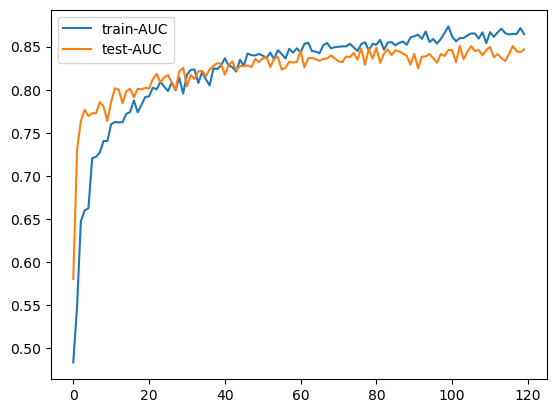

In [21]:
plot_metrics(metrics)

## Random substructure removal

In [8]:
pipeline = PNAPipeline(augmenter_kind="rnd-struct", smiles=smiles)
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.278 - Test Loss 0.434- AUC Train 0.910 - AUC Test 0.840 : 100%|██████████| 120/120 [08:36<00:00,  4.31s/it]


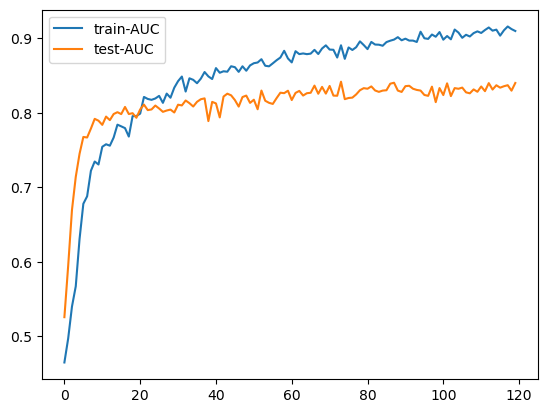

In [9]:
plot_metrics(metrics)

## Composition of random atom masking followed by random bond deletion

In [10]:
pipeline = PNAPipeline(augmenter_kind="rnd-comp", smiles=smiles)
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.364 - Test Loss 0.501- AUC Train 0.828 - AUC Test 0.831 : 100%|██████████| 120/120 [22:10<00:00, 11.09s/it]


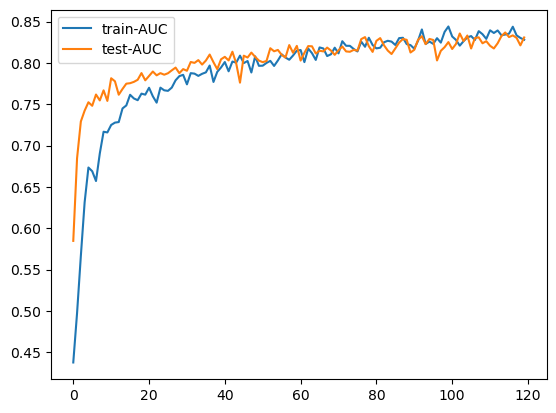

In [11]:
plot_metrics(metrics)

## One of random atom masking or random bond deletion

In [12]:
pipeline = PNAPipeline(augmenter_kind="rnd-one-off", smiles=smiles)
metrics = pipeline.fit(X_train, y_train, X_test, y_test)

Epoch 119 - Train Loss 0.318 - Test Loss 0.518- AUC Train 0.879 - AUC Test 0.835 : 100%|██████████| 120/120 [15:34<00:00,  7.79s/it]


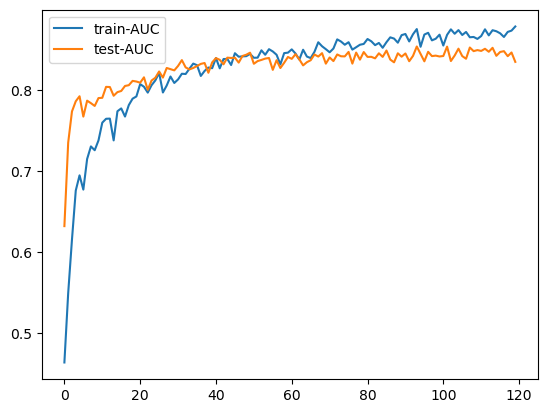

In [13]:
plot_metrics(metrics)

# Assess batch size x capacity x learning rate x learning rate decay

In [15]:
from functools import partial
from hyperopt import fmin, hp, tpe, space_eval, STATUS_OK

import pandas as pd
import numpy as np
import math


tuning_space = {
    'num_epochs': 120,
    'batch_size': hp.randint('batch_size', 16, 128),
    'hidden_channels': hp.randint('hidden_channels', 64, 128),
    'num_layers': hp.randint('num_layers', 2, 4),
    'dropout': hp.uniform('dropout', 0.0, 0.3),
    'learning_rate': hp.uniform('learning_rate', 1e-4, 1e-3),
    'lr_gamma': hp.uniform('lr_gamma', 0.9, 1.0)
}


def minimization_function(selected_hp_values, X_train, X_test, y_train, y_test):
    pipeline = PNAPipeline(
        num_epochs=int(selected_hp_values["num_epochs"]),
        batch_size=int(selected_hp_values["batch_size"]),
        hidden_channels=int(selected_hp_values["hidden_channels"]),
        num_layers=int(selected_hp_values["num_layers"]),
        dropout=float(selected_hp_values["dropout"]),
        learning_rate=float(selected_hp_values["learning_rate"]),
        lr_gamma=float(selected_hp_values["lr_gamma"])
    )
    metrics = pipeline.fit(X_train, y_train, X_test, y_test)
    last_10_mean_test_auc = np.mean(metrics["test_aucs"][-10:])
    return {'loss': -last_10_mean_test_auc, 'status': STATUS_OK}


def run_tuning(X_train, X_test, y_train, y_test, tuning_space):
    # determine optimal hyper param values
    tuning = fmin(fn=partial(minimization_function,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test),
                  space=tuning_space,
                  algo=tpe.suggest,
                  max_evals=20)

    # get the best run from above
    best_run = space_eval(tuning_space, tuning)

    return tuning, best_run


############## Call ################
tuning, best_run = run_tuning(X_train, X_test, y_train, y_test, tuning_space)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-05-26 16:29:59 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.001781 seconds
2023-05-26 16:29:59 | INFO | hyperopt.tpe | TPE using 0 trials
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 34.371 - Test Loss 1.309- AUC Train 0.487 - AUC Test 0.543 :   0%|          | 0/120 [00:04<?, ?it/s]

Epoch 0 - Train Loss 34.371 - Test Loss 1.309- AUC Train 0.487 - AUC Test 0.543 :   1%|          | 1/120 [00:04<09:51,  4.97s/it]

Epoch 1 - Train Loss 0.634 - Test Loss 0.571- AUC Train 0.477 - AUC Test 0.569 :   1%|          | 1/120 [00:09<09:51,  4.97s/it] 

Epoch 1 - Train Loss 0.634 - Test Loss 0.571- AUC Train 0.477 - AUC Test 0.569 :   2%|1         | 2/120 [00:09<08:56,  4.54s/it]

Epoch 2 - Train Loss 0.530 - Test Loss 0.498- AUC Train 0.477 - AUC Test 0.607 :   2%|1         | 2/120 [00:13<08:56,  4.54s/it]

Epoch 2 - Train Loss 0.530 - Test Loss 0.498- AUC Train 0.477 - AUC Test 0.607 :   2%|2         | 3/120 [00:13<08:19,  4.27s/it]

Epoch 3 - Train Loss 0.561 - Te

  5%|▌         | 1/20 [07:52<2:29:42, 472.76s/trial, best loss: -0.7668971837439639]

2023-05-26 16:37:52 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.004539 seconds
2023-05-26 16:37:52 | INFO | hyperopt.tpe | TPE using 1/1 trials with best loss -0.766897
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.590 - Test Loss 0.505- AUC Train 0.486 - AUC Test 0.536 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 1.590 - Test Loss 0.505- AUC Train 0.486 - AUC Test 0.536 :   1%|          | 1/120 [00:05<11:44,  5.92s/it]

Epoch 1 - Train Loss 0.515 - Test Loss 0.497- AUC Train 0.429 - AUC Test 0.552 :   1%|          | 1/120 [00:12<11:44,  5.92s/it]

Epoch 1 - Train Loss 0.515 - Test Loss 0.497- AUC Train 0.429 - AUC Test 0.552 :   2%|1         | 2/120 [00:12<12:50,  6.53s/it]

Epoch 2 - Train Loss 0.500 - Test Loss 0.494- AUC Train 0.438 - AUC Test 0.559 :   2%|1         | 2/120 [00:18<12:50,  6.53s/it]

Epoch 2 - Train Loss 0.500 - Test Loss 0.494- AUC Train 0.438 - AUC Test 0.559 :   2%|2         | 3/120 [00:18<12:07,  6.22s/it]

Epoch 3

 10%|█         | 2/20 [19:24<3:00:23, 601.32s/trial, best loss: -0.8585901096189771]

2023-05-26 16:49:23 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005441 seconds
2023-05-26 16:49:23 | INFO | hyperopt.tpe | TPE using 2/2 trials with best loss -0.858590
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.518 - Test Loss 0.501- AUC Train 0.422 - AUC Test 0.540 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 0.518 - Test Loss 0.501- AUC Train 0.422 - AUC Test 0.540 :   1%|          | 1/120 [00:03<06:34,  3.31s/it]

Epoch 1 - Train Loss 0.492 - Test Loss 0.497- AUC Train 0.494 - AUC Test 0.629 :   1%|          | 1/120 [00:06<06:34,  3.31s/it]

Epoch 1 - Train Loss 0.492 - Test Loss 0.497- AUC Train 0.494 - AUC Test 0.629 :   2%|1         | 2/120 [00:06<06:26,  3.28s/it]

Epoch 2 - Train Loss 0.469 - Test Loss 0.435- AUC Train 0.602 - AUC Test 0.754 :   2%|1         | 2/120 [00:09<06:26,  3.28s/it]

Epoch 2 - Train Loss 0.469 - Test Loss 0.435- AUC Train 0.602 - AUC Test 0.754 :   2%|2         | 3/120 [00:09<06:25,  3.29s/it]

Epoch 3

 15%|█▌        | 3/20 [26:00<2:23:50, 507.67s/trial, best loss: -0.8699848436784041]

2023-05-26 16:56:00 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005562 seconds
2023-05-26 16:56:00 | INFO | hyperopt.tpe | TPE using 3/3 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.727 - Test Loss 0.577- AUC Train 0.475 - AUC Test 0.467 :   0%|          | 0/120 [00:07<?, ?it/s]

Epoch 0 - Train Loss 0.727 - Test Loss 0.577- AUC Train 0.475 - AUC Test 0.467 :   1%|          | 1/120 [00:07<14:38,  7.38s/it]

Epoch 1 - Train Loss 0.510 - Test Loss 0.508- AUC Train 0.455 - AUC Test 0.488 :   1%|          | 1/120 [00:13<14:38,  7.38s/it]

Epoch 1 - Train Loss 0.510 - Test Loss 0.508- AUC Train 0.455 - AUC Test 0.488 :   2%|1         | 2/120 [00:13<13:15,  6.74s/it]

Epoch 2 - Train Loss 0.505 - Test Loss 0.500- AUC Train 0.454 - AUC Test 0.532 :   2%|1         | 2/120 [00:19<13:15,  6.74s/it]

Epoch 2 - Train Loss 0.505 - Test Loss 0.500- AUC Train 0.454 - AUC Test 0.532 :   2%|2         | 3/120 [00:19<12:43,  6.53s/it]

Epoch 3

 20%|██        | 4/20 [38:56<2:43:35, 613.49s/trial, best loss: -0.8699848436784041]

2023-05-26 17:08:55 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.004209 seconds
2023-05-26 17:08:55 | INFO | hyperopt.tpe | TPE using 4/4 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.813 - Test Loss 0.502- AUC Train 0.456 - AUC Test 0.563 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 0.813 - Test Loss 0.502- AUC Train 0.456 - AUC Test 0.563 :   1%|          | 1/120 [00:05<09:59,  5.04s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.496- AUC Train 0.441 - AUC Test 0.567 :   1%|          | 1/120 [00:11<09:59,  5.04s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.496- AUC Train 0.441 - AUC Test 0.567 :   2%|1         | 2/120 [00:11<11:34,  5.89s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.483- AUC Train 0.461 - AUC Test 0.644 :   2%|1         | 2/120 [00:16<11:34,  5.89s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.483- AUC Train 0.461 - AUC Test 0.644 :   2%|2         | 3/120 [00:17<11:07,  5.70s/it]

Epoch 3

 25%|██▌       | 5/20 [49:17<2:34:07, 616.49s/trial, best loss: -0.8699848436784041]

2023-05-26 17:19:17 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005986 seconds
2023-05-26 17:19:17 | INFO | hyperopt.tpe | TPE using 5/5 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.844 - Test Loss 0.559- AUC Train 0.480 - AUC Test 0.461 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 0.844 - Test Loss 0.559- AUC Train 0.480 - AUC Test 0.461 :   1%|          | 1/120 [00:03<06:37,  3.34s/it]

Epoch 1 - Train Loss 0.518 - Test Loss 0.501- AUC Train 0.475 - AUC Test 0.529 :   1%|          | 1/120 [00:06<06:37,  3.34s/it]

Epoch 1 - Train Loss 0.518 - Test Loss 0.501- AUC Train 0.475 - AUC Test 0.529 :   2%|1         | 2/120 [00:06<06:32,  3.33s/it]

Epoch 2 - Train Loss 0.495 - Test Loss 0.501- AUC Train 0.482 - AUC Test 0.599 :   2%|1         | 2/120 [00:09<06:32,  3.33s/it]

Epoch 2 - Train Loss 0.495 - Test Loss 0.501- AUC Train 0.482 - AUC Test 0.599 :   2%|2         | 3/120 [00:09<06:27,  3.31s/it]

Epoch 3

 30%|███       | 6/20 [56:01<2:06:56, 544.03s/trial, best loss: -0.8699848436784041]

2023-05-26 17:26:01 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005698 seconds
2023-05-26 17:26:01 | INFO | hyperopt.tpe | TPE using 6/6 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.619 - Test Loss 0.522- AUC Train 0.486 - AUC Test 0.575 :   0%|          | 0/120 [00:06<?, ?it/s]

Epoch 0 - Train Loss 1.619 - Test Loss 0.522- AUC Train 0.486 - AUC Test 0.575 :   1%|          | 1/120 [00:06<12:08,  6.12s/it]

Epoch 1 - Train Loss 0.509 - Test Loss 0.502- AUC Train 0.458 - AUC Test 0.582 :   1%|          | 1/120 [00:11<12:08,  6.12s/it]

Epoch 1 - Train Loss 0.509 - Test Loss 0.502- AUC Train 0.458 - AUC Test 0.582 :   2%|1         | 2/120 [00:11<11:01,  5.61s/it]

Epoch 2 - Train Loss 0.503 - Test Loss 0.545- AUC Train 0.480 - AUC Test 0.630 :   2%|1         | 2/120 [00:16<11:01,  5.61s/it]

Epoch 2 - Train Loss 0.503 - Test Loss 0.545- AUC Train 0.480 - AUC Test 0.630 :   2%|2         | 3/120 [00:16<10:34,  5.43s/it]

Epoch 3

 35%|███▌      | 7/20 [1:06:56<2:05:43, 580.29s/trial, best loss: -0.8699848436784041]

2023-05-26 17:36:56 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005948 seconds
2023-05-26 17:36:56 | INFO | hyperopt.tpe | TPE using 7/7 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.045 - Test Loss 0.498- AUC Train 0.465 - AUC Test 0.578 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 1.045 - Test Loss 0.498- AUC Train 0.465 - AUC Test 0.578 :   1%|          | 1/120 [00:03<07:50,  3.95s/it]

Epoch 1 - Train Loss 0.501 - Test Loss 0.491- AUC Train 0.468 - AUC Test 0.611 :   1%|          | 1/120 [00:08<07:50,  3.95s/it]

Epoch 1 - Train Loss 0.501 - Test Loss 0.491- AUC Train 0.468 - AUC Test 0.611 :   2%|1         | 2/120 [00:08<08:48,  4.48s/it]

Epoch 2 - Train Loss 0.496 - Test Loss 0.479- AUC Train 0.518 - AUC Test 0.662 :   2%|1         | 2/120 [00:12<08:48,  4.48s/it]

Epoch 2 - Train Loss 0.496 - Test Loss 0.479- AUC Train 0.518 - AUC Test 0.662 :   2%|2         | 3/120 [00:12<08:29,  4.35s/it]

Epoch 3

 40%|████      | 8/20 [1:15:09<1:50:32, 552.68s/trial, best loss: -0.8699848436784041]

2023-05-26 17:45:09 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.004455 seconds
2023-05-26 17:45:09 | INFO | hyperopt.tpe | TPE using 8/8 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.850 - Test Loss 0.505- AUC Train 0.497 - AUC Test 0.594 :   0%|          | 0/120 [00:06<?, ?it/s]

Epoch 0 - Train Loss 1.850 - Test Loss 0.505- AUC Train 0.497 - AUC Test 0.594 :   1%|          | 1/120 [00:07<13:53,  7.00s/it]

Epoch 1 - Train Loss 0.534 - Test Loss 0.624- AUC Train 0.484 - AUC Test 0.576 :   1%|          | 1/120 [00:14<13:53,  7.00s/it]

Epoch 1 - Train Loss 0.534 - Test Loss 0.624- AUC Train 0.484 - AUC Test 0.576 :   2%|1         | 2/120 [00:14<13:51,  7.05s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.549- AUC Train 0.529 - AUC Test 0.624 :   2%|1         | 2/120 [00:21<13:51,  7.05s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.549- AUC Train 0.529 - AUC Test 0.624 :   2%|2         | 3/120 [00:21<13:45,  7.06s/it]

Epoch 3

 45%|████▌     | 9/20 [1:29:25<1:58:41, 647.39s/trial, best loss: -0.8699848436784041]

2023-05-26 17:59:25 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.002328 seconds
2023-05-26 17:59:25 | INFO | hyperopt.tpe | TPE using 9/9 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.804 - Test Loss 0.648- AUC Train 0.471 - AUC Test 0.441 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 1.804 - Test Loss 0.648- AUC Train 0.471 - AUC Test 0.441 :   1%|          | 1/120 [00:05<10:35,  5.34s/it]

Epoch 1 - Train Loss 0.608 - Test Loss 1.147- AUC Train 0.494 - AUC Test 0.481 :   1%|          | 1/120 [00:10<10:35,  5.34s/it]

Epoch 1 - Train Loss 0.608 - Test Loss 1.147- AUC Train 0.494 - AUC Test 0.481 :   2%|1         | 2/120 [00:10<10:29,  5.34s/it]

Epoch 2 - Train Loss 0.628 - Test Loss 1.328- AUC Train 0.478 - AUC Test 0.489 :   2%|1         | 2/120 [00:16<10:29,  5.34s/it]

Epoch 2 - Train Loss 0.628 - Test Loss 1.328- AUC Train 0.478 - AUC Test 0.489 :   2%|2         | 3/120 [00:16<10:24,  5.34s/it]

Epoch 3

 50%|█████     | 10/20 [1:40:25<1:48:33, 651.37s/trial, best loss: -0.8699848436784041]

2023-05-26 18:10:25 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003612 seconds
2023-05-26 18:10:25 | INFO | hyperopt.tpe | TPE using 10/10 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.841 - Test Loss 0.526- AUC Train 0.464 - AUC Test 0.486 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 0.841 - Test Loss 0.526- AUC Train 0.464 - AUC Test 0.486 :   1%|          | 1/120 [00:03<07:15,  3.66s/it]

Epoch 1 - Train Loss 0.513 - Test Loss 0.514- AUC Train 0.492 - AUC Test 0.559 :   1%|          | 1/120 [00:07<07:15,  3.66s/it]

Epoch 1 - Train Loss 0.513 - Test Loss 0.514- AUC Train 0.492 - AUC Test 0.559 :   2%|1         | 2/120 [00:07<07:12,  3.67s/it]

Epoch 2 - Train Loss 0.527 - Test Loss 0.498- AUC Train 0.488 - AUC Test 0.618 :   2%|1         | 2/120 [00:10<07:12,  3.67s/it]

Epoch 2 - Train Loss 0.527 - Test Loss 0.498- AUC Train 0.488 - AUC Test 0.618 :   2%|2         | 3/120 [00:10<07:08,  3.66s/it]

Epoch

 55%|█████▌    | 11/20 [1:47:56<1:28:29, 589.99s/trial, best loss: -0.8699848436784041]

2023-05-26 18:17:56 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.002997 seconds
2023-05-26 18:17:56 | INFO | hyperopt.tpe | TPE using 11/11 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 4.907 - Test Loss 0.657- AUC Train 0.489 - AUC Test 0.637 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 4.907 - Test Loss 0.657- AUC Train 0.489 - AUC Test 0.637 :   1%|          | 1/120 [00:03<06:00,  3.03s/it]

Epoch 1 - Train Loss 0.531 - Test Loss 0.524- AUC Train 0.473 - AUC Test 0.658 :   1%|          | 1/120 [00:06<06:00,  3.03s/it]

Epoch 1 - Train Loss 0.531 - Test Loss 0.524- AUC Train 0.473 - AUC Test 0.658 :   2%|1         | 2/120 [00:06<06:31,  3.32s/it]

Epoch 2 - Train Loss 0.499 - Test Loss 0.478- AUC Train 0.508 - AUC Test 0.654 :   2%|1         | 2/120 [00:10<06:31,  3.32s/it]

Epoch 2 - Train Loss 0.499 - Test Loss 0.478- AUC Train 0.508 - AUC Test 0.654 :   2%|2         | 3/120 [00:10<06:51,  3.51s/it]

Epoch

 60%|██████    | 12/20 [1:54:18<1:10:13, 526.74s/trial, best loss: -0.8699848436784041]

2023-05-26 18:24:18 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003729 seconds
2023-05-26 18:24:18 | INFO | hyperopt.tpe | TPE using 12/12 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.292 - Test Loss 0.502- AUC Train 0.455 - AUC Test 0.556 :   0%|          | 0/120 [00:02<?, ?it/s]

Epoch 0 - Train Loss 1.292 - Test Loss 0.502- AUC Train 0.455 - AUC Test 0.556 :   1%|          | 1/120 [00:02<05:54,  2.98s/it]

Epoch 1 - Train Loss 0.505 - Test Loss 0.507- AUC Train 0.469 - AUC Test 0.565 :   1%|          | 1/120 [00:05<05:54,  2.98s/it]

Epoch 1 - Train Loss 0.505 - Test Loss 0.507- AUC Train 0.469 - AUC Test 0.565 :   2%|1         | 2/120 [00:05<05:53,  2.99s/it]

Epoch 2 - Train Loss 0.498 - Test Loss 0.514- AUC Train 0.486 - AUC Test 0.607 :   2%|1         | 2/120 [00:09<05:53,  2.99s/it]

Epoch 2 - Train Loss 0.498 - Test Loss 0.514- AUC Train 0.486 - AUC Test 0.607 :   2%|2         | 3/120 [00:09<05:53,  3.02s/it]

Epoch

 65%|██████▌   | 13/20 [2:00:29<55:57, 479.63s/trial, best loss: -0.8699848436784041]  

2023-05-26 18:30:29 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.005161 seconds
2023-05-26 18:30:29 | INFO | hyperopt.tpe | TPE using 13/13 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.019 - Test Loss 0.574- AUC Train 0.479 - AUC Test 0.572 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 1.019 - Test Loss 0.574- AUC Train 0.479 - AUC Test 0.572 :   1%|          | 1/120 [00:05<10:18,  5.20s/it]

Epoch 1 - Train Loss 0.509 - Test Loss 0.563- AUC Train 0.485 - AUC Test 0.590 :   1%|          | 1/120 [00:10<10:18,  5.20s/it]

Epoch 1 - Train Loss 0.509 - Test Loss 0.563- AUC Train 0.485 - AUC Test 0.590 :   2%|1         | 2/120 [00:10<10:12,  5.19s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.484- AUC Train 0.540 - AUC Test 0.664 :   2%|1         | 2/120 [00:15<10:12,  5.19s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.484- AUC Train 0.540 - AUC Test 0.664 :   2%|2         | 3/120 [00:15<10:16,  5.27s/it]

Epoch

 70%|███████   | 14/20 [2:11:11<52:51, 528.52s/trial, best loss: -0.8699848436784041]

2023-05-26 18:41:11 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003499 seconds
2023-05-26 18:41:11 | INFO | hyperopt.tpe | TPE using 14/14 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.649 - Test Loss 0.523- AUC Train 0.440 - AUC Test 0.548 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 0.649 - Test Loss 0.523- AUC Train 0.440 - AUC Test 0.548 :   1%|          | 1/120 [00:05<11:51,  5.98s/it]

Epoch 1 - Train Loss 0.502 - Test Loss 0.501- AUC Train 0.456 - AUC Test 0.576 :   1%|          | 1/120 [00:12<11:51,  5.98s/it]

Epoch 1 - Train Loss 0.502 - Test Loss 0.501- AUC Train 0.456 - AUC Test 0.576 :   2%|1         | 2/120 [00:12<11:49,  6.01s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.493- AUC Train 0.512 - AUC Test 0.661 :   2%|1         | 2/120 [00:17<11:49,  6.01s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.493- AUC Train 0.512 - AUC Test 0.661 :   2%|2         | 3/120 [00:17<11:40,  5.98s/it]

Epoch

 75%|███████▌  | 15/20 [2:23:33<49:24, 592.98s/trial, best loss: -0.8699848436784041]

2023-05-26 18:53:33 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.002588 seconds
2023-05-26 18:53:33 | INFO | hyperopt.tpe | TPE using 15/15 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 1.007 - Test Loss 0.567- AUC Train 0.443 - AUC Test 0.456 :   0%|          | 0/120 [00:06<?, ?it/s]

Epoch 0 - Train Loss 1.007 - Test Loss 0.567- AUC Train 0.443 - AUC Test 0.456 :   1%|          | 1/120 [00:06<12:00,  6.06s/it]

Epoch 1 - Train Loss 0.507 - Test Loss 0.532- AUC Train 0.452 - AUC Test 0.476 :   1%|          | 1/120 [00:12<12:00,  6.06s/it]

Epoch 1 - Train Loss 0.507 - Test Loss 0.532- AUC Train 0.452 - AUC Test 0.476 :   2%|1         | 2/120 [00:12<11:50,  6.02s/it]

Epoch 2 - Train Loss 0.505 - Test Loss 0.522- AUC Train 0.465 - AUC Test 0.486 :   2%|1         | 2/120 [00:18<11:50,  6.02s/it]

Epoch 2 - Train Loss 0.505 - Test Loss 0.522- AUC Train 0.465 - AUC Test 0.486 :   2%|2         | 3/120 [00:18<11:41,  5.99s/it]

Epoch

 80%|████████  | 16/20 [2:35:42<42:15, 633.85s/trial, best loss: -0.8699848436784041]

2023-05-26 19:05:42 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.004871 seconds
2023-05-26 19:05:42 | INFO | hyperopt.tpe | TPE using 16/16 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 3.087 - Test Loss 0.511- AUC Train 0.495 - AUC Test 0.563 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 3.087 - Test Loss 0.511- AUC Train 0.495 - AUC Test 0.563 :   1%|          | 1/120 [00:05<10:17,  5.19s/it]

Epoch 1 - Train Loss 0.503 - Test Loss 0.503- AUC Train 0.452 - AUC Test 0.590 :   1%|          | 1/120 [00:10<10:17,  5.19s/it]

Epoch 1 - Train Loss 0.503 - Test Loss 0.503- AUC Train 0.452 - AUC Test 0.590 :   2%|1         | 2/120 [00:10<10:08,  5.16s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.517- AUC Train 0.481 - AUC Test 0.595 :   2%|1         | 2/120 [00:15<10:08,  5.16s/it]

Epoch 2 - Train Loss 0.497 - Test Loss 0.517- AUC Train 0.481 - AUC Test 0.595 :   2%|2         | 3/120 [00:15<10:03,  5.16s/it]

Epoch

 85%|████████▌ | 17/20 [2:46:23<31:48, 636.06s/trial, best loss: -0.8699848436784041]

2023-05-26 19:16:23 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003920 seconds
2023-05-26 19:16:23 | INFO | hyperopt.tpe | TPE using 17/17 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.507 - Test Loss 0.513- AUC Train 0.433 - AUC Test 0.509 :   0%|          | 0/120 [00:05<?, ?it/s]

Epoch 0 - Train Loss 0.507 - Test Loss 0.513- AUC Train 0.433 - AUC Test 0.509 :   1%|          | 1/120 [00:05<10:51,  5.48s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.506- AUC Train 0.435 - AUC Test 0.553 :   1%|          | 1/120 [00:10<10:51,  5.48s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.506- AUC Train 0.435 - AUC Test 0.553 :   2%|1         | 2/120 [00:10<10:42,  5.45s/it]

Epoch 2 - Train Loss 0.482 - Test Loss 0.471- AUC Train 0.534 - AUC Test 0.715 :   2%|1         | 2/120 [00:16<10:42,  5.45s/it]

Epoch 2 - Train Loss 0.482 - Test Loss 0.471- AUC Train 0.534 - AUC Test 0.715 :   2%|2         | 3/120 [00:16<10:34,  5.42s/it]

Epoch

 90%|█████████ | 18/20 [2:57:32<21:31, 645.85s/trial, best loss: -0.8699848436784041]

2023-05-26 19:27:32 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003056 seconds
2023-05-26 19:27:32 | INFO | hyperopt.tpe | TPE using 18/18 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.576 - Test Loss 0.508- AUC Train 0.425 - AUC Test 0.512 :   0%|          | 0/120 [00:04<?, ?it/s]

Epoch 0 - Train Loss 0.576 - Test Loss 0.508- AUC Train 0.425 - AUC Test 0.512 :   1%|          | 1/120 [00:04<09:48,  4.94s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.504- AUC Train 0.435 - AUC Test 0.530 :   1%|          | 1/120 [00:09<09:48,  4.94s/it]

Epoch 1 - Train Loss 0.500 - Test Loss 0.504- AUC Train 0.435 - AUC Test 0.530 :   2%|1         | 2/120 [00:09<09:48,  4.99s/it]

Epoch 2 - Train Loss 0.500 - Test Loss 0.497- AUC Train 0.452 - AUC Test 0.560 :   2%|1         | 2/120 [00:14<09:48,  4.99s/it]

Epoch 2 - Train Loss 0.500 - Test Loss 0.497- AUC Train 0.452 - AUC Test 0.560 :   2%|2         | 3/120 [00:14<09:44,  4.99s/it]

Epoch

 95%|█████████▌| 19/20 [3:07:43<10:35, 635.59s/trial, best loss: -0.8699848436784041]

2023-05-26 19:37:43 | INFO | hyperopt.tpe | build_posterior_wrapper took 0.003154 seconds
2023-05-26 19:37:43 | INFO | hyperopt.tpe | TPE using 19/19 trials with best loss -0.869985
  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0 - Train Loss 0.775 - Test Loss 0.564- AUC Train 0.473 - AUC Test 0.551 :   0%|          | 0/120 [00:03<?, ?it/s]

Epoch 0 - Train Loss 0.775 - Test Loss 0.564- AUC Train 0.473 - AUC Test 0.551 :   1%|          | 1/120 [00:03<06:50,  3.45s/it]

Epoch 1 - Train Loss 0.549 - Test Loss 0.475- AUC Train 0.513 - AUC Test 0.668 :   1%|          | 1/120 [00:06<06:50,  3.45s/it]

Epoch 1 - Train Loss 0.549 - Test Loss 0.475- AUC Train 0.513 - AUC Test 0.668 :   2%|1         | 2/120 [00:06<06:49,  3.47s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.551- AUC Train 0.590 - AUC Test 0.752 :   2%|1         | 2/120 [00:10<06:49,  3.47s/it]

Epoch 2 - Train Loss 0.502 - Test Loss 0.551- AUC Train 0.590 - AUC Test 0.752 :   2%|2         | 3/120 [00:10<06:46,  3.47s/it]

Epoch

100%|██████████| 20/20 [3:14:48<00:00, 584.40s/trial, best loss: -0.8699848436784041]


In [17]:
best_run

{'batch_size': 61,
 'dropout': 0.05384651727102755,
 'hidden_channels': 77,
 'learning_rate': 0.0003457762995254392,
 'lr_gamma': 0.9243830282543076,
 'num_epochs': 120,
 'num_layers': 2}